# Implementation of MutiClass Logistic Regression using Tensorflow core

- The TensorFlow Core APIs provide access to low level functionality within the TensorFlow ecosystem. This API provides more flexibility and control for building ML models, applications, and tools, compared to high-level APIs, such as Keras.

> Multiclass logistic regression is a type of classification algorithm used to solve multi-class classification problems. It is an extension of binary logistic regression, which is used for binary classification tasks. In multiclass logistic regression, we aim to classify input samples into one of several possible classes.

> The main idea behind multiclass logistic regression is to model the relationship between the input features and the probabilities of each class using the softmax function. The softmax function takes a vector of logits (unnormalized scores) and transforms it into a probability distribution over the classes.

**Declaimer**:
- This notebook is going to fruiful for those who already are familier with the math behind the multiclass logistic regression but not with tensorflow core implementation.

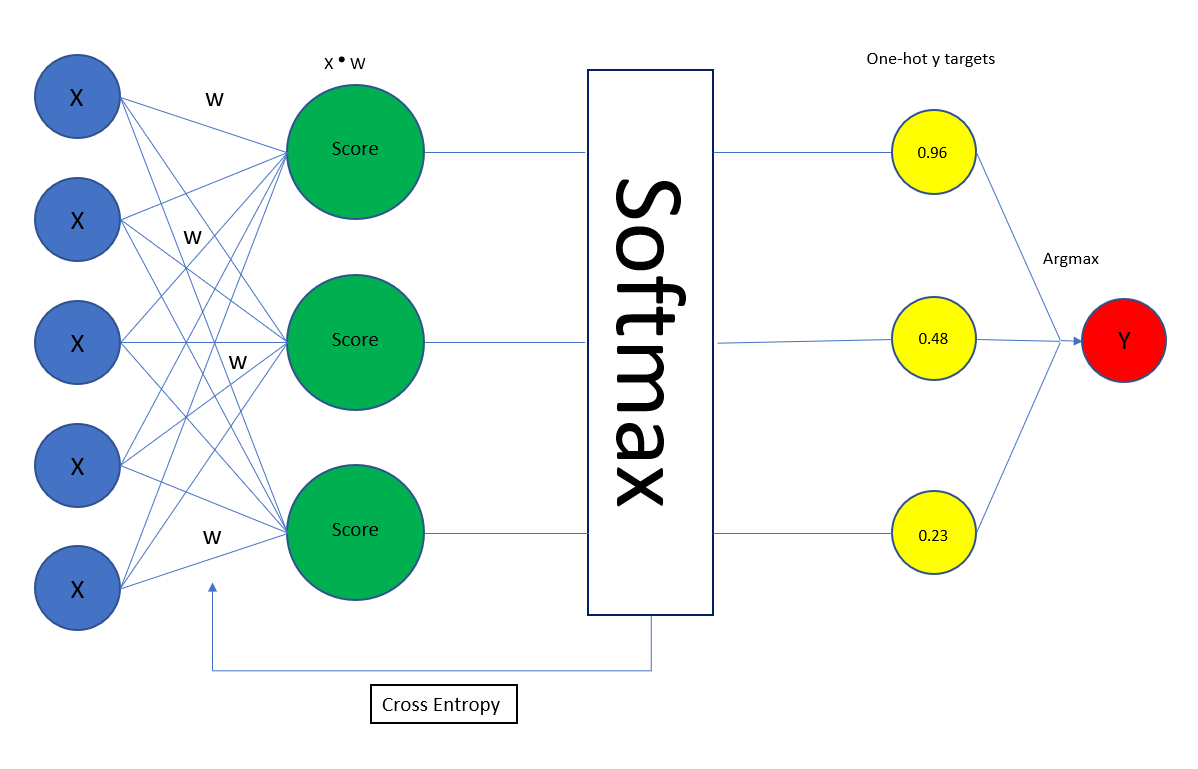

**Figure 1: Structure of multinomial logistic regression**

**src:** https://medium.com/ds3ucsd/multinomial-logistic-regression-in-a-nutshell-53c94b30448f 

- Below figure illustrates how we implement the above conceptual diagram of multiclass logistic regression using linear algebra.
- Note that the input shape could also be (n_examples, input_features), as a result the weights, bias and the logits calculation must also be changed accordingly. I'm following Andrew Ng's convention that he have used in coursera deeplearning specialization course.
- Here, **n_examples** represents a batch_size, we can process each example individually (by adopting vector representation insted of matrix). To laverage the parallel computation, it is best practice to process a batch of data.

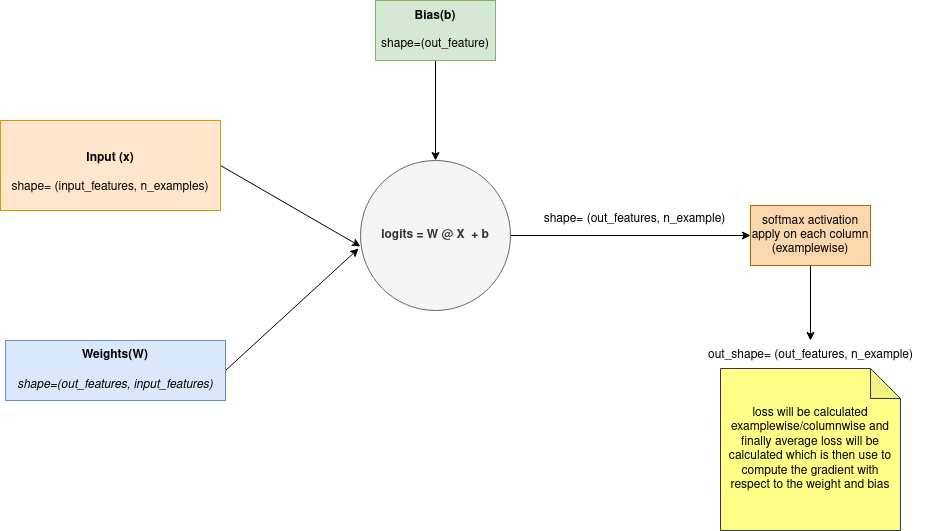

**Figure: Forward Pass with input and output shape**

Here's a high-level overview of how multiclass logistic regression works:
- **Data:** Gather a dataset containing input samples and their corresponding class labels. Each input sample should be represented by a feature vector, and the class labels should be integers representing the class index.

- **Model:** Define a model that consists of a set of weights and biases for each class. The model computes the logits for each class by taking a dot product between the feature vector and the corresponding class weights, and then adding the class bias.

- **Softmax Activation:** Apply the softmax function to the logits to convert them into probabilities. The softmax function normalizes the logits so that the sum of the probabilities across all classes is equal to 1.

- **Loss Function:** Define the cross-entropy loss function, which measures the dissimilarity between the predicted probabilities and the true class labels. The goal is to minimize this loss function during training.

- **Training:** Use an optimization algorithm (e.g., gradient descent) to find the optimal weights and biases that minimize the loss function. This process involves iteratively updating the model parameters using the gradients of the loss function with respect to the model's parameters.

- **Inference:** Once the model is trained, you can use it to make predictions on new, unseen input samples by computing the probabilities using the softmax function and selecting the class with the highest probability as the predicted class.


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2023-07-19 13:24:22.412274: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-19 13:24:22.453869: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-19 13:24:22.454809: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 13:24:23.157056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# We are setting this random seed inorder to get persistent result while generating random numbers
SEED = 4 # if you want different result you can change the seed value
tf.random.set_seed(SEED)

In [3]:
tf.random.normal((1,2))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.07676513, -0.2082602 ]], dtype=float32)>

**expected_out** = <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.07676513, -0.2082602 ]], dtype=float32)> for SEED = 4

**Note**: If you re-execute the tf.random.number() the result will be changed, but if you execut it after execution of the above random.set_seed() statiment, you will always get the same result.

# Load data

We will be using MNIST dataset. In the future, we will prepare dataset using various methods.

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
print("x_train shape: ",x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
x_test shape:  (10000, 28, 28)
y_test shape:  (10000,)


- We can see we have 60K training data where each images are of size 28*28 and 10K test data which is pretty good number of dataset, however in this notebook we are not going to focus on the model performance, instead of that we will be focusing on building model using tensorflow core.
- We are only going to use a chunk of training data and not going to test the model performance in the test data.

In [6]:
NUM_CLASSES = len(np.unique(y_train))
print(f"There are {NUM_CLASSES} unique classes in this dataset")

There are 10 unique classes in this dataset


In [7]:
# let's view the dataset
def show_data(index, x, y):
    plt.figure(figsize=(20,4))
    for i in range(index, index+5):
        img = x[i]
        label = y[i]
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title('Training: %i\n' % label, fontsize = 15);

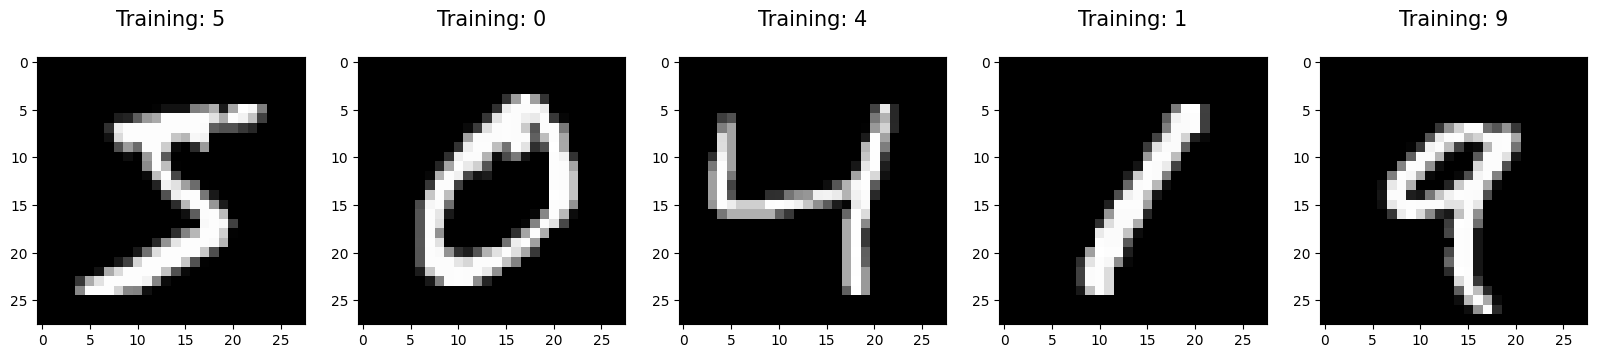

In [8]:
show_data(0, x_train, y_train)

# Preprocess the data

- multclass logistic regression takes only 1D input vector (here we are ignoring batch dimension), we have to transform 28*28 2D matrix into 784 1D vector.
- In simple words, We are not using convolution neural network, we will be treating each pixel of an image as input feature. So for 28X28 image, there will be 28\*28 = 784 input features.
- So in comparision with above diagram we have input(X) shape = (input_features, n_examples) = (784, 60000)

In [9]:
x_train = tf.reshape(x_train, shape=(x_train.shape[0], -1))
x_test = tf.reshape(x_test, shape=(x_test.shape[0], -1))

Now let's apply transpose operation to the metrix so the we have (784, 60000) shape.
- Note that, tf.cast perform typecasting, we need to typecast the tensor into float32 must of the time, or else tensorflow throws error.

In [10]:
x_train = tf.cast(tf.transpose(x_train), "float32")
x_test = tf.cast(tf.transpose(x_test), "float32")
y_train = tf.constant(y_train)
print("New x_train shape: ", x_train.shape)
print("New x_test shape: ", x_test.shape)

New x_train shape:  (784, 60000)
New x_test shape:  (784, 10000)


2023-07-19 13:24:25.054756: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Now, we have 2D metrics where row (784) represents the 1D vector represention of the input image whereas each columns (60000) represents each examples.

In [11]:
# Normalization helps to transform input values of varying range into the range of 0 to 1.
class Normalize(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
    def norm(self, x):
        # normalize the input image
        return x / 255.
    def denorm(self, x):
        return x*255.

In [12]:
norm_x = Normalize()

In [13]:
normalized_x = norm_x.norm(x_train[:, 0])
tf.math.reduce_all(tf.equal(x_train[:, 0], norm_x.denorm(normalized_x))).numpy()

True

- **tf.math.reduce_all()** is a TensorFlow function used to compute the logical AND reduction of elements in a tensor along the specified axes.
- It confirms that the both the original x and denormalized after normalizing x are equal.


We show also check whether the values are mapped to 0-1 range or not.

In [14]:
# initially it is in the range 0 - 255
tf.reduce_min(x_train).numpy(), tf.reduce_max(x_test).numpy()

(0.0, 255.0)

In [15]:
# Now we normalize our data
x_train = norm_x.norm(x_train)
x_test = norm_x.norm(x_test)

2023-07-19 13:24:25.188168: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


In [16]:
tf.reduce_min(x_train).numpy(), tf.reduce_max(x_test).numpy()

(0.0, 1.0)

# Softmax Activation Function
The softmax activation function is a commonly used activation function in the output layer of a neural network for multi-class classification tasks. It converts raw class scores (logits) into normalized probabilities, making it suitable for problems where an input can belong to one of multiple exclusive classes.

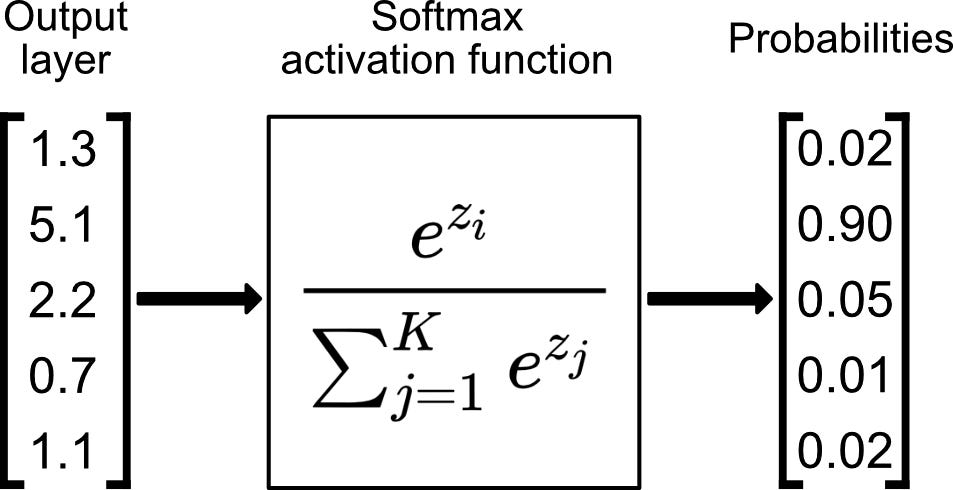

In [17]:
def softmax(x):
#     x shape --> (num_features, num_examples)
    max_logits = tf.reduce_max(x, axis=0, keepdims=True)
    # this line is essential, it helps to scale down the y_pred
    ex_x = tf.math.exp(x - max_logits)
    sum_ex = tf.reduce_sum(ex_x, axis=0, keepdims=True)
#     print("shape:", sum_ex.shape, ex_x.shape)
#     print("ex_x", ex_x)
#     print("sum_ex: ", sum_ex)
    softmax_x = ex_x / (sum_ex)
    return softmax_x

In [18]:
# Testing softmax function
x = tf.constant([[1.3, 0.32],
                 [5.1, -45.5],
                 [2.2, 2.233],
                 [0.7, -1.23],
                 [1.1, 0.65]])
softmax_x = softmax(x)
print("Softmax of x: ", softmax_x)

Softmax of x:  tf.Tensor(
[[2.01904643e-02 1.06648520e-01]
 [9.02537644e-01 1.34456240e-21]
 [4.96605337e-02 7.22370863e-01]
 [1.10807605e-02 2.26359311e-02]
 [1.65305529e-02 1.48344696e-01]], shape=(5, 2), dtype=float32)


In [19]:
# we can verify whether our softmax function is working fine or not by simply adding value along axis=0, it should be 1
print(" Verification of softmax: ", tf.reduce_sum(softmax_x, axis=0).numpy())

 Verification of softmax:  [0.99999994 1.        ]


# Custom Loss Function
- **CrossEntropy Loss:**

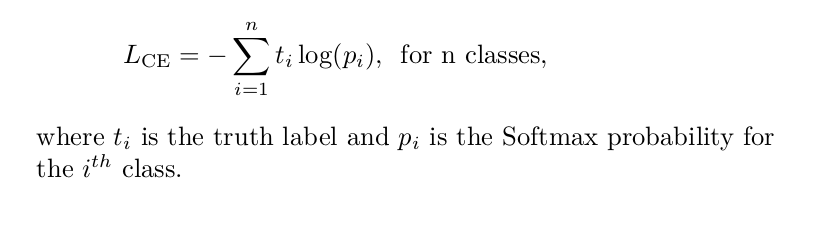

**Note:** In keras lossfunction API, there is this from_logits parameter,
 - **from_logits=True** means the input to crossEntropy layer is normal tensor/logits, 
 - **from_logits=False**, means the input is a probability and usually you should have some softmax activation in your last layer.

In [20]:
# since we will be applying softmax function in the last layer,
# we will use crossentroy loss withh from_logits = False
def sparse_categorical_crossentropy_loss(y_true, y_pred, from_logits=False):
    # Here  y_true shape --> (num_examples)
    # y_pred shape --> (out_class, num_examples)
    if from_logits:
        y_pred = softmax(y_pred)
        
    #here depth parameter takes number of features/classes    
    one_hot_y_true = tf.transpose(tf.one_hot(y_true, depth=y_pred.shape[0])) 
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    log_y_pred = tf.math.log(y_pred)
    mul = tf.multiply(one_hot_y_true, log_y_pred)    
    losses = -tf.reduce_sum(mul, axis=0)
    return tf.reduce_mean(losses)

In [21]:
# Testing loss function
y_true = tf.constant([0, 1, 0])
y_pred = tf.constant([[1., 0., 1.0],
                      [0., 1., 0.]])

sparse_categorical_crossentropy_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1920929e-07>

In [22]:
# compare the above result with the keras API
tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, axis=0))

<tf.Tensor: shape=(), dtype=float32, numpy=1.1920928e-07>

You can test with different values, I have done and it is working fine.

# Model Building

Multiclass logistic regression, also known as softmax regression, is a type of classification algorithm used to classify input data into multiple exclusive classes. It is an extension of binary logistic regression, which is used for binary classification tasks. Multiclass logistic regression is particularly useful when you have more than two classes in your classification problem.

In [23]:
class MultiClassLogisticRegression(tf.Module):
    def __init__(self, n_classes, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.is_built = False
        self.n_class = n_classes
    
    def build(self, num_features):
        # randomly generate bias and weights
        self.weights = tf.Variable(tf.random.uniform([self.n_class, num_features]), name="weights")
        self.bias = tf.Variable(tf.zeros([self.n_class, 1]), name="bias")
        print("build successfully")
        
    def predict(self, x):
        #compute model output
        # compute logits
        logits = self.weights @ x + self.bias
        sm = softmax(logits)
        return sm
    
    def __call__(self, x):
        if not self.is_built:
            self.build(x.shape[0])
            self.is_built = True
        return self.predict(x)

In [25]:
model = MultiClassLogisticRegression(10)
output = model(x_train[:, :10])
output.shape, output[:, 0]

build successfully


(TensorShape([10, 10]),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8.4899166e-06, 1.0017405e-02, 2.0980898e-02, 1.0328888e-02,
        3.5297181e-03, 8.0998266e-01, 3.3668714e-04, 1.0828340e-02,
        1.2887363e-01, 5.1132878e-03], dtype=float32)>)

In [26]:
model.variables

(<tf.Variable 'bias:0' shape=(10, 1) dtype=float32, numpy=
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32)>,
 <tf.Variable 'weights:0' shape=(10, 784) dtype=float32, numpy=
 array([[0.94965684, 0.47409856, 0.16003454, ..., 0.31575096, 0.08451676,
         0.29920197],
        [0.09902859, 0.36181855, 0.03085053, ..., 0.535668  , 0.03182912,
         0.30217946],
        [0.3009702 , 0.7170963 , 0.03548574, ..., 0.2558049 , 0.09494579,
         0.37129557],
        ...,
        [0.7318754 , 0.79906654, 0.04790211, ..., 0.83630943, 0.63355064,
         0.38755333],
        [0.79358256, 0.18423712, 0.02140677, ..., 0.84221303, 0.75294757,
         0.92924035],
        [0.41646826, 0.94520843, 0.23258531, ..., 0.25210547, 0.3238467 ,
         0.34268653]], dtype=float32)>)

# Accuracy Metrics
Let's define an accuracy metrics to check the model accuracy in each epoch.

In [27]:
def calculate_accuracy(y_true, y_pred):
    y_pred = tf.cast(tf.argmax(y_pred), "int32")
    y_true = tf.cast(y_true, "int32")
    matches = tf.cast(tf.equal(y_true, y_pred), "float32")
    return tf.reduce_mean(matches)

## Fit Function
- Now, let's define a train function where we compute model output, calculate loss and accuracy, calculate gradient descent and at last we will apply **batch gradient descent** to adjust the weight. 
- We show return the loss and accuracy, to see how well our model is performing after each epoch.

In [28]:
# defining training function
def train(model, x_train, y_train, learning_rate=0.01):
    loss = 0
    with tf.GradientTape() as tape:
        y_pred = model(x_train)
        acc = calculate_accuracy(y_train, y_pred)
        loss = sparse_categorical_crossentropy_loss(y_train, y_pred)
    dw, db = tape.gradient(loss, [model.weights, model.bias])
    # applying batch gradient descent 
    # w = w - lr * dloss/dw
    model.weights.assign_sub(learning_rate * dw)
    model.bias.assign_sub(learning_rate * db)
    return loss, acc

In [29]:
# sample train data, let's only use the first 10K dataset only
x_train_sample = x_train[:, :10_000]
y_train_sample = y_train[:10_000]

In [30]:
model = MultiClassLogisticRegression(10)
output = model(x_train_sample)
output

build successfully


<tf.Tensor: shape=(10, 10000), dtype=float32, numpy=
array([[1.7900871e-01, 1.0754148e-03, 4.2996705e-03, ..., 7.6410100e-02,
        6.9500610e-02, 5.7316460e-03],
       [2.5318796e-03, 1.9368767e-05, 1.8707998e-03, ..., 2.8984164e-04,
        4.4073589e-02, 1.5708117e-02],
       [9.0558492e-02, 9.6509531e-05, 4.5404610e-01, ..., 3.1221224e-04,
        9.7724423e-03, 5.7123970e-02],
       ...,
       [1.0663562e-01, 8.0104306e-02, 2.6073179e-01, ..., 4.9482536e-04,
        2.3990119e-01, 1.4195263e-03],
       [5.0921328e-02, 9.1315728e-01, 1.3626385e-01, ..., 1.4000764e-03,
        4.6049407e-01, 5.5767310e-01],
       [2.4583413e-01, 4.3958197e-03, 3.1857507e-03, ..., 9.1442233e-01,
        3.5444260e-02, 3.3973426e-01]], dtype=float32)>

In [31]:
model.weights.shape, model.bias.shape

(TensorShape([10, 784]), TensorShape([10, 1]))

In [32]:
train(model, x_train_sample, y_train_sample, learning_rate=0.01)

(<tf.Tensor: shape=(), dtype=float32, numpy=4.6627545>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.068>)

- It seems our train function is working fine. 
- 4.8809 is the loss and 0.0658 is the accuracy

# Training Loop
Now we have to call the train function multiple time (epochs) to gradually improve the model performation or to train the model.

In [33]:
def display_training_summary(loss, accuracy, epoch):
    print(f"EPOCH: {epoch} --- loss: {loss}---accuracy: {accuracy}")

In [34]:
# to store loss and accuracy from each epoch
LOSS_HISTORY = []
ACC_HISTORY = []

# instantiate the model
model = MultiClassLogisticRegression(NUM_CLASSES)

In [35]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.1

#  Training Loop
for epoch in range(NUM_EPOCHS):
    loss, acc = train(model, x_train_sample, y_train_sample, LEARNING_RATE)
    LOSS_HISTORY.append(loss)
    ACC_HISTORY.append(acc)
    display_training_summary(loss, acc, epoch+1)

build successfully
EPOCH: 1 --- loss: 4.880951404571533---accuracy: 0.0658000037074089
EPOCH: 2 --- loss: 4.405190467834473---accuracy: 0.08579999953508377
EPOCH: 3 --- loss: 4.087174415588379---accuracy: 0.10949999839067459
EPOCH: 4 --- loss: 3.83807110786438---accuracy: 0.13009999692440033
EPOCH: 5 --- loss: 3.62516713142395---accuracy: 0.14489999413490295
EPOCH: 6 --- loss: 3.4369499683380127---accuracy: 0.15870000422000885
EPOCH: 7 --- loss: 3.2692368030548096---accuracy: 0.17219999432563782
EPOCH: 8 --- loss: 3.1200411319732666---accuracy: 0.18629999458789825
EPOCH: 9 --- loss: 2.9875690937042236---accuracy: 0.20029999315738678
EPOCH: 10 --- loss: 2.8695783615112305---accuracy: 0.2126999944448471
EPOCH: 11 --- loss: 2.7635107040405273---accuracy: 0.22529999911785126
EPOCH: 12 --- loss: 2.6669113636016846---accuracy: 0.23600000143051147
EPOCH: 13 --- loss: 2.5777668952941895---accuracy: 0.2498999983072281
EPOCH: 14 --- loss: 2.4946224689483643---accuracy: 0.26019999384880066
EPOCH:

after 100 epoch, the model accuracy is around 71% where as loss is around 0.88.

# Classifying test example

In [36]:
test_image = x_test[:, 2]
test_image = tf.reshape(test_image, shape=(-1, 1))

test_label = y_test[2]
test_image.shape

TensorShape([784, 1])

In [37]:
y_pred = model(test_image)
predicted_label = tf.argmax(y_pred, axis=0).numpy()[0]

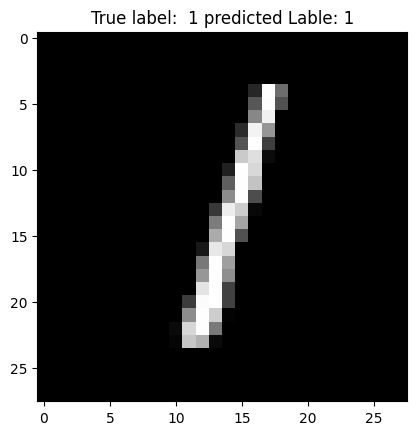

In [38]:
plt.title(f"True label:  {test_label} predicted Lable: {predicted_label}")
img = tf.reshape(test_image, shape=(28, 28)).numpy()
plt.imshow(img, cmap="gray")

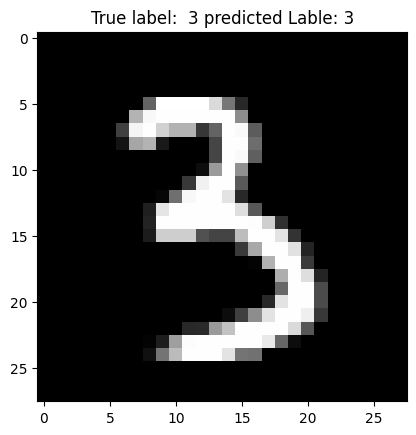

In [39]:
index = 32
test_image = x_test[:, index]
test_image = tf.reshape(test_image, shape=(-1, 1))
test_label = y_test[index]
y_pred = model(test_image)
predicted_label = tf.argmax(y_pred, axis=0).numpy()[0]

plt.title(f"True label:  {test_label} predicted Lable: {predicted_label}")
img = tf.reshape(test_image, shape=(28, 28)).numpy()
plt.imshow(img, cmap="gray")